In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import cv2
from skimage.measure import label, regionprops
from tqdm import tqdm

Loading training data

In [11]:
train_data1 = np.load('DL-Project/data0.npy')
train_data2 = np.load('DL-Project/data1.npy')
train_data3 = np.load('DL-Project/data2.npy')

res1 = np.load('DL-Project/lab0.npy')
res2 = np.load('DL-Project/lab1.npy')
res3 = np.load('DL-Project/lab2.npy')

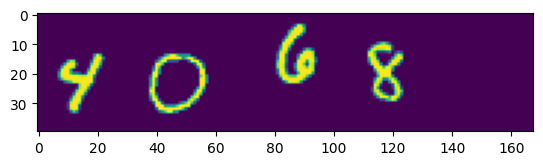

In [12]:
plt.imshow(train_data1[1])

In [13]:
print(res1[1])

18


In [27]:
import numpy as np
import cv2
from tqdm import tqdm
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import os

def threshold(img, thresh_value=125):
    # Binary threshold using vectorized operations instead of loops
    return np.where(img > thresh_value, 255, 0).astype(np.uint8)

def get_digits_regions_for_all_images(train_data, save_visualizations=False):
    # Store regions as regular list since they'll have different sizes
    digits_regions = []
    temp_image_path = 'temp_img.png'
    
    try:
        for i in tqdm(range(len(train_data))):
            # Save current image
            plt.figure(figsize=(8, 8))
            plt.imshow(train_data[i])
            plt.axis('off')
            plt.savefig(temp_image_path, bbox_inches='tight', pad_inches=0)
            plt.close()
            
            # Process image
            img = cv2.imread(temp_image_path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            thresh = threshold(gray)
            
            # Get connected components
            labels = label(thresh, connectivity=2)  # Using 2D connectivity
            regions = regionprops(labels)
            
            # Extract digit regions
            digit_regions_current = []
            for idx, region in enumerate(regions):
                if idx == 0:  # Skip first region (usually background)
                    continue
                    
                minr, minc, maxr, maxc = region.bbox
                digit_region = img[minr:maxr, minc:maxc].copy()
                digit_regions_current.append(digit_region)
                
                # Draw bounding box if visualizations are needed
                if save_visualizations:
                    cv2.rectangle(img, (minc, minr), (maxc, maxr), (0, 0, 0), 2)
            
            digits_regions.append(digit_regions_current)
            
            # Optional visualization
            if save_visualizations:
                plt.figure(figsize=(8, 8))
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.show()
                plt.close()
    
    finally:
        # Cleanup temporary file
        if os.path.exists(temp_image_path):
            os.remove(temp_image_path)
    
    return digits_regions

digits_regions = get_digits_regions_for_all_images(train_data1[0:200])
digits_regions_arr = np.array(digits_regions, dtype=object)
np.save('d0.npy', digits_regions_arr, allow_pickle=True)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:07<00:00, 26.67it/s]


In [31]:
def padding_digits_regions(digits_regions):
    padded_regions = []
    border_size = 15
    target_size = 28
    
    for region_group in digits_regions:
        group_regions = []
        for region in region_group:
            height, width = region.shape[:2]
            
            if height > target_size and width > target_size:
                padded_image = cv2.copyMakeBorder(
                    region,
                    border_size, border_size, border_size, border_size,
                    cv2.BORDER_CONSTANT,
                    value=[0, 0, 0]
                )
            else:
                base_image = np.zeros((target_size, target_size, 3), dtype=np.uint8)
                pad_height = max(0, (target_size - height) // 2)
                pad_width = max(0, (target_size - width) // 2)
                
                padded_image = cv2.copyMakeBorder(
                    region,
                    border_size, border_size, border_size, border_size,
                    cv2.BORDER_CONSTANT,
                    value=[0, 0, 0]
                )
            
            group_regions.append(padded_image)
        padded_regions.append(group_regions)
    
    return np.array(padded_regions, dtype=object)

def resize_images(padded_regions, target_size=(28, 28)):
    resized_images = []
    
    for region_group in padded_regions:
        group_images = []
        for region in region_group:
            resized = cv2.resize(region, target_size)
            group_images.append(resized)
        resized_images.append(group_images)
    
    return np.array(resized_images, dtype=object)

padded_regions_arr = padding_digits_regions(digits_regions_arr)
resized_images = resize_images(padded_regions_arr)

In [35]:
labels = np.array(res1[0:200])

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

def prepare_images_and_labels(resized_images, labels):
    processed_images = []
    processed_labels = []
    
    # Process each group of images
    for idx, group in enumerate(resized_images):
        for img in group:
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (28, 28))
            img = img.astype(np.float32) / 255.0
            processed_images.append(img)
            
            if idx < len(labels):
                processed_labels.append(labels[idx])
    
    processed_images = np.array(processed_images)
    processed_labels = np.array(processed_labels)
    
    # Ensure same number of samples
    min_samples = min(len(processed_images), len(processed_labels))
    processed_images = processed_images[:min_samples]
    processed_labels = processed_labels[:min_samples]
    
    # Adjust labels to be zero-based and within range
    unique_labels = np.unique(processed_labels)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    processed_labels = np.array([label_map[label] for label in processed_labels])
    
    num_classes = len(unique_labels)
    print(f"Number of processed images: {len(processed_images)}")
    print(f"Number of processed labels: {len(processed_labels)}")
    print(f"Number of unique classes: {num_classes}")
    print(f"Label range: {processed_labels.min()} to {processed_labels.max()}")
    
    return processed_images, processed_labels, num_classes

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def calculate_accuracy(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.train()
    best_val_accuracy = 0.0
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Calculate metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = calculate_accuracy(model, train_loader)
        val_loss = validate(model, val_loader, criterion)
        val_accuracy = calculate_accuracy(model, val_loader)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        print("-" * 60)
        
        # Save best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_accuracy,
                'val_loss': val_loss
            }, 'best_model.pth')
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered! Best validation accuracy: {best_val_accuracy:.2f}%")
            break
    
    # Load best model
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def validate(model, val_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Prepare the data
processed_images, processed_labels, num_classes = prepare_images_and_labels(resized_images, labels)
train_images = torch.tensor(processed_images, dtype=torch.float32).unsqueeze(1)
train_labels = torch.tensor(processed_labels, dtype=torch.long)

# Split data
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.3, random_state=42
)

# Create data loaders
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize model and training
model = CNNModel(50)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
model = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=3)

# Final evaluation
final_train_accuracy = calculate_accuracy(model, train_loader)
final_val_accuracy = calculate_accuracy(model, val_loader)
print(f"\nFinal Results:")
print(f"Training Accuracy: {final_train_accuracy:.2f}%")
print(f"Validation Accuracy: {final_val_accuracy:.2f}%")

Number of processed images: 225
Number of processed labels: 225
Number of unique classes: 24
Label range: 0 to 23
Epoch 1/20
Training Loss: 3.8652, Training Accuracy: 6.37%
Validation Loss: 3.8221, Validation Accuracy: 5.88%
------------------------------------------------------------
Epoch 2/20
Training Loss: 3.6038, Training Accuracy: 6.37%
Validation Loss: 3.6336, Validation Accuracy: 5.88%
------------------------------------------------------------
Epoch 3/20
Training Loss: 3.4282, Training Accuracy: 9.55%
Validation Loss: 3.5923, Validation Accuracy: 8.82%
------------------------------------------------------------
Epoch 4/20
Training Loss: 3.1934, Training Accuracy: 10.19%
Validation Loss: 3.4917, Validation Accuracy: 7.35%
------------------------------------------------------------
Epoch 5/20
Training Loss: 3.0864, Training Accuracy: 10.83%
Validation Loss: 3.3584, Validation Accuracy: 5.88%
------------------------------------------------------------
Epoch 6/20
Training Loss